In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [5]:
movies = pd.read_csv("movies.csv")
ratings = pd.read_csv("ratings.csv")
tags = pd.read_csv("tags.csv")
 
movies.info()
ratings.info()
tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-nul

In [6]:
# Kiểm tra và loại bỏ dữ liệu thiếu
movies.dropna(inplace=True)
ratings.dropna(inplace=True)
tags.dropna(inplace=True)

# Loại bỏ duplicate nếu có
movies.drop_duplicates(inplace=True)
ratings.drop_duplicates(inplace=True)

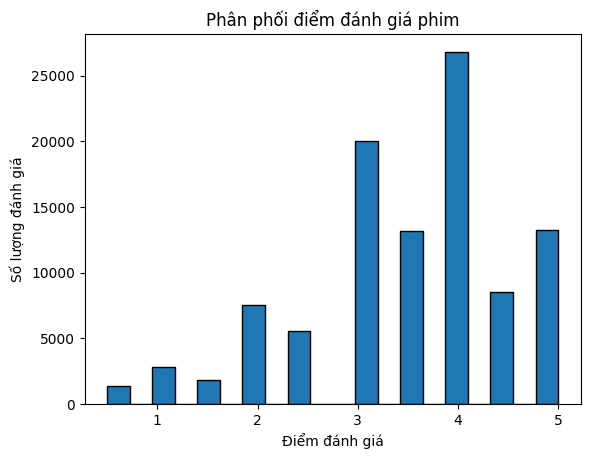

In [7]:
# Thống kê rating
ratings['rating'].hist(bins=20, edgecolor='black')
plt.title("Phân phối điểm đánh giá phim")
plt.xlabel("Điểm đánh giá")
plt.ylabel("Số lượng đánh giá")
plt.grid(False)
plt.show()

In [8]:
import seaborn as sns
# Top phim được đánh giá nhiều nhất
top_movies = ratings.groupby("movieId")['rating'].count().sort_values(ascending=False).head(10)
top_movies = pd.merge(top_movies, movies, on='movieId')
print(top_movies[['title', 'rating']])


                                       title  rating
0                        Forrest Gump (1994)     329
1           Shawshank Redemption, The (1994)     317
2                        Pulp Fiction (1994)     307
3           Silence of the Lambs, The (1991)     279
4                         Matrix, The (1999)     278
5  Star Wars: Episode IV - A New Hope (1977)     251
6                       Jurassic Park (1993)     238
7                          Braveheart (1995)     237
8          Terminator 2: Judgment Day (1991)     224
9                    Schindler's List (1993)     220


In [9]:
print("Ratings:")
print(ratings.describe())

print("\nSố lượng phim:", movies['movieId'].nunique())
print("Số lượng người dùng:", ratings['userId'].nunique())
print("Số rating trung bình trên mỗi phim:", ratings.groupby('movieId').size().mean())


Ratings:
              userId        movieId         rating     timestamp
count  100836.000000  100836.000000  100836.000000  1.008360e+05
mean      326.127564   19435.295718       3.501557  1.205946e+09
std       182.618491   35530.987199       1.042529  2.162610e+08
min         1.000000       1.000000       0.500000  8.281246e+08
25%       177.000000    1199.000000       3.000000  1.019124e+09
50%       325.000000    2991.000000       3.500000  1.186087e+09
75%       477.000000    8122.000000       4.000000  1.435994e+09
max       610.000000  193609.000000       5.000000  1.537799e+09

Số lượng phim: 9742
Số lượng người dùng: 610
Số rating trung bình trên mỗi phim: 10.369806663924312


In [10]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
# Tạo ma trận người dùng - phim
user_movie_matrix = ratings.pivot_table(index='userId', columns='movieId', values='rating').fillna(0)

# === KNN user-based Collaborative Filtering ===
user_similarity = cosine_similarity(user_movie_matrix)
user_similarity_df = pd.DataFrame(user_similarity, index=user_movie_matrix.index, columns=user_movie_matrix.index)

# Gợi ý: dự đoán điểm đánh giá user u cho movie m
def predict_rating_knn(user_id, movie_id, k=5):
    if movie_id not in user_movie_matrix.columns:
        return np.nan

    # Lấy k người dùng giống user_id nhất
    sim_scores = user_similarity_df[user_id].drop(index=user_id).sort_values(ascending=False)[:k]
    top_users = sim_scores.index
    ratings_by_top_users = user_movie_matrix.loc[top_users, movie_id]
    weighted_ratings = ratings_by_top_users * sim_scores
    return weighted_ratings.sum() / sim_scores[ratings_by_top_users.notnull()].sum()


In [11]:
# SVD giảm chiều dữ liệu
svd = TruncatedSVD(n_components=20)
svd_matrix = svd.fit_transform(user_movie_matrix)

# Dự đoán lại ma trận đánh giá
reconstructed = np.dot(svd_matrix, svd.components_)
reconstructed_df = pd.DataFrame(reconstructed, index=user_movie_matrix.index, columns=user_movie_matrix.columns)


In [12]:
# Tạo tập test
train, test = train_test_split(ratings, test_size=0.2, random_state=42)

# Dự đoán từ reconstructed SVD
y_true = []
y_pred = []

for _, row in test.iterrows():
    uid = row['userId']
    mid = row['movieId']
    true = row['rating']
    try:
        pred = reconstructed_df.loc[uid, mid]
        y_true.append(true)
        y_pred.append(pred)
    except:
        continue

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)

print(f"RMSE: {rmse:.4f}, MAE: {mae:.4f}")


RMSE: 2.3668, MAE: 1.9846


In [13]:
from sklearn.metrics import precision_score, recall_score

# Định nghĩa nhãn: >= 4 là thích
y_true_labels = [1 if r >= 4.0 else 0 for r in y_true]
y_pred_labels = [1 if r >= 4.0 else 0 for r in y_pred]

precision = precision_score(y_true_labels, y_pred_labels, zero_division=0)
recall = recall_score(y_true_labels, y_pred_labels, zero_division=0)

print(f"Precision: {precision}")
print(f"Recall:    {recall}")


Precision: 0.8823038397328882
Recall:    0.1090702713858219


In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Tính TF-IDF từ tiêu đề phim
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movies['title'])

cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Lấy danh sách phim tương tự
def get_recommendations(title, cosine_sim=cosine_sim):
    idx = movies[movies['title'] == title].index[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:6]
    return movies.iloc[[i[0] for i in sim_scores]]['title']

print(get_recommendations('Toy Story (1995)'))


2355     Toy Story 2 (1999)
7355     Toy Story 3 (2010)
3595        Toy, The (1982)
4089    Toy Soldiers (1991)
26      Now and Then (1995)
Name: title, dtype: object
